In [1]:
from google.colab import drive

# Google Drive 마운트
print("Google Drive를 마운트합니다...")
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [43]:
import tensorflow_datasets as tfds

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='assets/tf_flowers/',
    download=False,
    with_info=True,
    as_supervised=True,
)

print(len(raw_train))
print(len(raw_validation))
print(len(raw_test))

2936
367
367


In [44]:
import tensorflow as tf

def format_dtype(image, label):
  image = tf.cast(image, tf.float32)
  return image, label

train = raw_train.map(format_dtype)
validation = raw_validation.map(format_dtype)
test = raw_test.map(format_dtype)

# 채널수와 dtype 모두 확인하기
print(train.element_spec)
print(validation.element_spec)
print(test.element_spec)

(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [56]:
# 1️⃣ Min-Max Scaling (0~1 범위)
def normalize_min_max(image):
    return image / 255.0  # 0~1 범위로 변환

# 2️⃣ Zero-Centering (-1~1 범위)
def normalize_zero_center(image):
    return (image / 127.5) - 1  # -1 ~ 1 범위로 변환

# 3️⃣ Mean-Std Normalization (사전 학습 모델용)
def normalize_mean_std(image):
    imagenet_mean = [123.68, 116.78, 103.94]  # ImageNet RGB 평균 값
    imagenet_std = [58.393, 57.12, 57.375]  # ImageNet RGB 표준 편차
    return (image - imagenet_mean) / imagenet_std  # Z-Score 정규화

In [ ]:
from collections import Counter

# 1. 이미지 해상도 통계 파악
def get_resolution_stats(dataset):
    resolutions = []
    for image, _ in dataset:
        resolutions.append(image.shape[:2])  # (height, width)
    resolution_counts = Counter(resolutions)
    return resolution_counts

# 2. 해상도 통계 출력 함수
def print_resolution_stats(stats):
    print("=== 해상도 통계 ===")
    for resolution, count in stats.items():
        print(f"  해상도 {resolution}: {count}개")

# 3. 데이터셋 통계 파악 및 출력
train_res_stats = get_resolution_stats(train)
validation_res_stats = get_resolution_stats(validation)
test_res_stats = get_resolution_stats(test)

print("훈련 데이터셋 해상도 통계")
print_resolution_stats(train_res_stats)

print("\n검증 데이터셋 해상도 통계")
print_resolution_stats(validation_res_stats)

print("\n테스트 데이터셋 해상도 통계")
print_resolution_stats(test_res_stats)

# 4. 전체 데이터셋 통계 합산
total_res_stats = train_res_stats + validation_res_stats + test_res_stats
print("\n전체 데이터셋 해상도 통계")
print_resolution_stats(total_res_stats)

# 클래스 분포 확인


📊 train 클래스 분포:
  Class 0: 557개
  Class 1: 386개
  Class 2: 452개
  Class 3: 418개
  Class 4: 389개


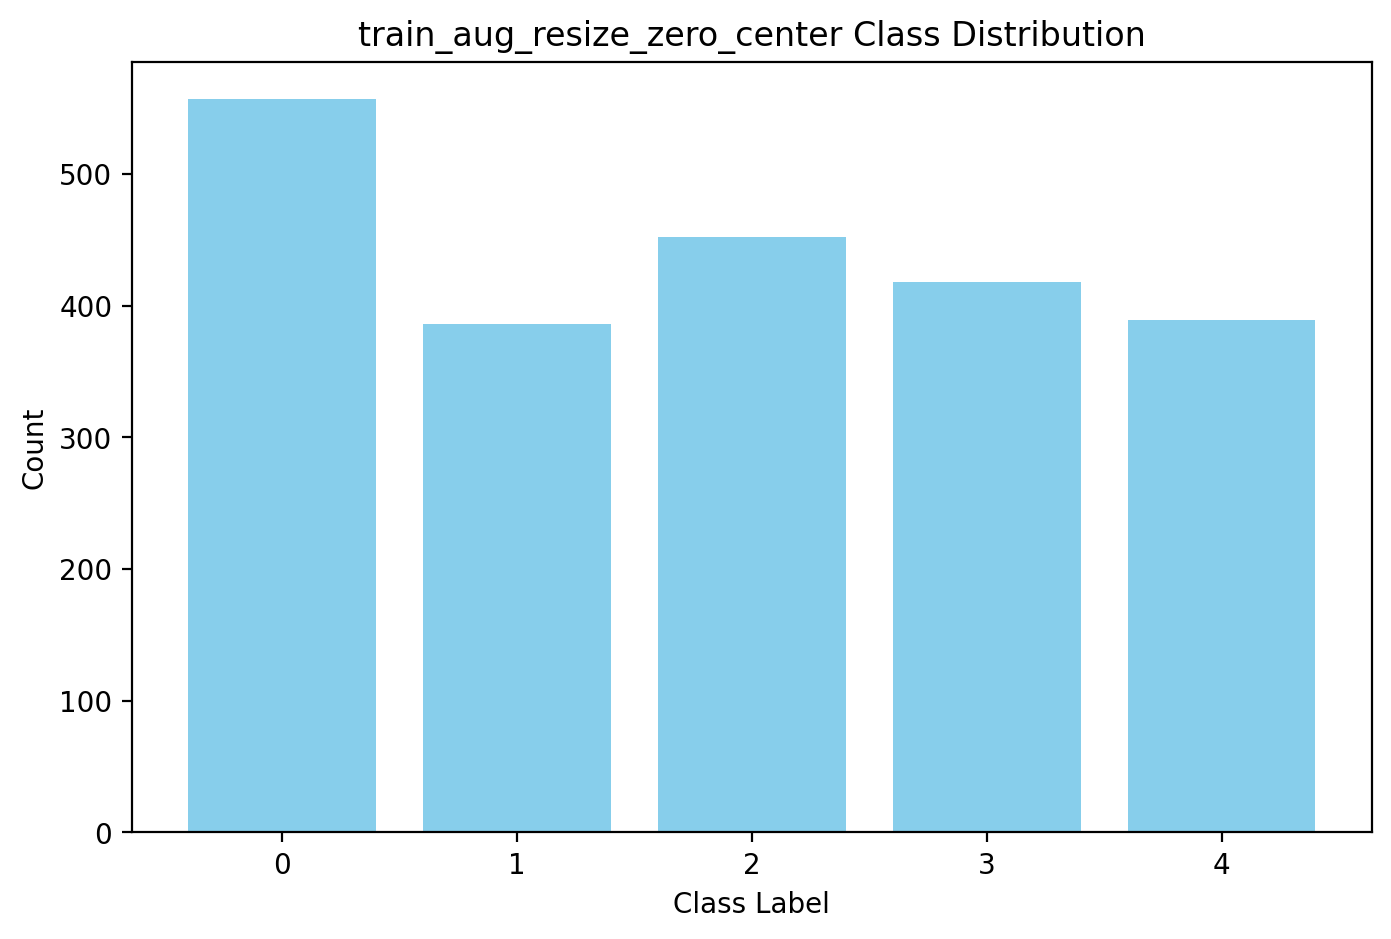

In [72]:
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter

# 클래스 개수 카운트 함수
def count_labels(dataset, dataset_name):
    label_counts = Counter()

    for _, label in dataset.as_numpy_iterator():  # tf.data를 numpy 변환 후 라벨만 카운트
        label_counts[label] += 1

    # 클래스별 개수 출력
    print(f"📊 {dataset_name} 클래스 분포:")
    for label, count in sorted(label_counts.items()):
        print(f"  Class {label}: {count}개")

    return label_counts

# 데이터셋별 클래스 분포 확인
train_aug_counts = count_labels(train, "train")
# train_min_max_counts = count_labels(train_min_max_resize, "train_min_max_resize")

# 📊 시각화
def plot_class_distribution(label_counts, title):
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(labels)
    plt.show()

# 🔥 클래스 분포 그래프 출력
plot_class_distribution(train_aug_counts, "train_aug_resize_zero_center Class Distribution")
# plot_class_distribution(train_min_max_counts, "train_min_max_resize Class Distribution")

In [57]:
IMG_SIZE = 224

def resize_with_pad(image, label, target_size=(IMG_SIZE, IMG_SIZE)):
    image = tf.image.resize_with_pad(image, target_size[0], target_size[1])
    return image, label

def resize_image(image, label, target_size=(IMG_SIZE, IMG_SIZE)):
    image = tf.image.resize(image, target_size)
    return image, label

In [58]:
import tensorflow as tf

def augment_random(image, label):
    # 1️⃣ 좌우 반전 (50% 확률)
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_flip_left_right(image)

    # 2️⃣ 랜덤 회전 (90도 단위)
    if tf.random.uniform(()) < 0.5:
        k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)

    # 3️⃣ 랜덤 밝기 조절 (최대 ±20%, 50% 확률)
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.2)

    # 4️⃣ 랜덤 대비 조절 (90% ~ 110%, 50% 확률)
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # 5️⃣ 랜덤 줌 (90% ~ 110%, 50% 확률)
    if tf.random.uniform(()) < 0.5:
        zoom_factor = tf.random.uniform([], minval=0.9, maxval=1.1)

        # tf.shape(image)[0]과 [1]을 float32로 변환
        height = tf.cast(tf.cast(tf.shape(image)[0], tf.float32) * zoom_factor, tf.int32)
        width = tf.cast(tf.cast(tf.shape(image)[1], tf.float32) * zoom_factor, tf.int32)

        image = tf.image.resize_with_crop_or_pad(image, height, width)
        image = tf.image.resize(image, (224, 224))  # 원래 크기로 복구

    return image, label

In [59]:
# 원본 + 증강 데이터셋 3배 크기로 확장
def expand_dataset(original, augmented):
    return original.concatenate(augmented.repeat(2))  # 원본 + 증강된 데이터 2배 추가 = 총 3배 크기

# 데이터셋 준비 및 시각화로 확인


In [70]:
# 1. 리사이즈만 한 데이터
train_resize_only = train.map(resize_image)
validation_resize_only = validation.map(resize_image)
test_resize_only = test.map(resize_image)

# 2. 리사이즈 -> 정규화 (Min-Max Scaling)
train_resize_min_max = train.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))
validation_resize_min_max = validation.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))
test_resize_min_max = test.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))

# 3. 정규화 (Min-Max Scaling) -> 리사이즈
train_min_max_resize = train.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)
validation_min_max_resize = validation.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)
test_min_max_resize = test.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)

# 4. 정규화 (Zero-Centering) -> 리사이즈
train_zero_center_resize = train.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_image)
validation_zero_center_resize = validation.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_image)
test_zero_center_resize = test.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_image)

# 5. 정규화 (Zero-Centering) -> 리사이즈 (패딩)
train_zero_center_resize_with_pad = train.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_with_pad)
validation_zero_center_resize_with_pad = validation.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_with_pad)
test_zero_center_resize_with_pad = test.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_with_pad)

# 6. 증강 → 리사이즈 → 정규화 (Min-Max Scaling)
train_aug_resize_min_max = expand_dataset(
    train.map(resize_image).map(lambda x, y: (normalize_min_max(x), y)),
    train.map(augment_random).map(resize_image).map(lambda x, y: (normalize_min_max(x), y))
)
validation_aug_resize_min_max = validation.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))
test_aug_resize_min_max = test.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))

# 7. 증강 → 리사이즈 → 정규화 (Zero-Centering)
train_aug_resize_zero_center = expand_dataset(
    train.map(resize_image).map(lambda x, y: (normalize_zero_center(x), y)),
    train.map(augment_random).map(resize_image).map(lambda x, y: (normalize_zero_center(x), y))
)
validation_aug_resize_zero_center = validation.map(resize_image).map(lambda x, y: (normalize_zero_center(x), y))
test_aug_resize_zero_center = test.map(resize_image).map(lambda x, y: (normalize_zero_center(x), y))

# 8. 증강 -> 정규화 (Min-Max) -> 리사이즈
train_aug_min_max_resize = expand_dataset(
    train.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image),
    train.map(augment_random).map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)
)
validation_aug_min_max_resize = validation.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)
test_aug_min_max_resize = test.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)

# 9. 정규화 (Zero-Centering) -> 증강 -> 리사이즈
train_zero_center_aug_resize = expand_dataset(
    train.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_image),
    train.map(lambda x, y: (normalize_zero_center(x), y)).map(augment_random).map(resize_image)
)
validation_zero_center_aug_resize = validation.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_image)
test_zero_center_aug_resize = test.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_image)

# 10. 정규화 (Min-Max) -> 증강 -> 리사이즈
train_min_max_aug_resize = expand_dataset(
    train.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image),
    train.map(lambda x, y: (normalize_min_max(x), y)).map(augment_random).map(resize_image)
)
validation_min_max_aug_resize = validation.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)
test_min_max_aug_resize = test.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)

# 11. 증강 → 리사이즈 → 정규화 (Zero-Centering)
train_aug_resize_min_max = expand_dataset(
    train.map(resize_image).map(lambda x, y: (normalize_min_max(x), y)),
    train.map(augment_random).map(resize_image).map(lambda x, y: (normalize_min_max(x), y))
)
validation_aug_resize_min_max = validation.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))
test_aug_resize_min_max = test.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))

# 12. 증강 -> 리사이즈
train_aug_resize = expand_dataset(
    train.map(resize_image),
    train.map(augment_random).map(resize_image)
)
validation_aug_resize = validation.map(resize_image)
test_aug_resize = test.map(resize_image)

# 13. 증강 -> 리사이즈
train_aug_resize_with_pad = expand_dataset(
    train.map(resize_image),
    train.map(augment_random).map(resize_with_pad)
)
validation_aug_resize_with_pad = validation.map(resize_with_pad)
test_aug_resize_with_pad = test.map(resize_with_pad)

In [71]:
MODEL_TRAIN = train_aug_resize
MODEL_VALIDATION = validation_aug_resize
MODEL_TEST = test_aug_resize

In [229]:
import tensorflow as tf
import matplotlib.pyplot as plt
# 별도의 팝업창으로 열지 않고 바로 노트북 파일에 노출
# %matplotlib inline 하지만 없어도 그냥 잘됨.. (현재로서는)
# 해상도 향상 하기
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(20, 10))

get_label_name = metadata.features['label'].int2str

# 비정규화 함수
def denormalize_image(image, norm_type="min_max"):
    if norm_type == "min_max":  # Min-Max Scaling (0~1 범위)
        return (image * 255.0).numpy().astype("uint8")
    elif norm_type == "zero_center":  # Zero-Centering (-1~1 범위)
        # return ((image + 1) * 127.5).numpy().astype("uint8")
        return (image + 1) / 2
    elif norm_type == "mean_std":  # Mean-Std Normalization
        imagenet_mean = [123.68, 116.78, 103.94]
        imagenet_std = [58.393, 57.12, 57.375]
        return ((image * imagenet_std) + imagenet_mean).numpy().astype("uint8")
    else:
        raise ValueError("Unsupported normalization type")

for idx, (image, label) in enumerate(MODEL_TRAIN.take(20)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(4, 5, idx+1)

    # 정규화 해제 (0~1 범위로 변환)
    # image = (image + 1) / 2
    image = denormalize_image(image, norm_type="min_max")

    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 모델


In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

In [231]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dropout(0.5),
    Dense(units=5, activation='softmax')
])

model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,476,549 (196.37 MB)

 Trainable params: 51,476,549 (196.37 MB)

 Non-trainable params: 0 (0.00 B)

In [325]:
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

# 사용할 사전 학습 모델 선택 (ResNet50, VGG16, EfficientNet 등)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# CNN의 마지막 몇 개 레이어만 학습 가능하게 설정 (전체는 X)
base_model.trainable = True
for layer in base_model.layers[:-30]:  # 마지막 30개 레이어만 학습
    layer.trainable = False

# 모델 구성
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Flatten보다 더 좋은 일반화 성능
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # L2 적용
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5개 클래스 분류
])

# 모델 요약 정보 출력
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 15,501,829 (59.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling, Resizing, RandomFlip, RandomRotation, RandomZoom, BatchNormalization
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0

# 사전 학습된 모델 로드 (일반 CNN 모델 사용 시, Conv2D 층 직접 쌓으면 됨)
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False  # Feature Extractor로 사용

# 모델 구성
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(512, activation='relu'),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(5, activation='softmax')
])

In [74]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_size = sum(1 for _ in MODEL_TRAIN)
test_size = sum(1 for _ in MODEL_TEST)
validation_size = sum(1 for _ in MODEL_VALIDATION)
validation_steps = validation_size // BATCH_SIZE
if validation_size % BATCH_SIZE != 0:
    validation_steps += 1  # 남은 데이터 처리
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")
print(f"Validation size: {validation_size}")
print(f"Validation steps: {validation_steps}")

for image, label in MODEL_TRAIN.take(5):
    print(f"Image shape: {image.shape}, Label: {label.numpy()}")

Train size: 8808
Test size: 367
Validation size: 367
Validation steps: 12
Image shape: (224, 224, 3), Label: 2
Image shape: (224, 224, 3), Label: 3
Image shape: (224, 224, 3), Label: 3
Image shape: (224, 224, 3), Label: 4
Image shape: (224, 224, 3), Label: 3


2025-01-31 15:07:10.288663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-31 15:07:10.343344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-31 15:07:10.396137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-31 15:07:10.438715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [75]:
steps_per_epoch = train_size // BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=steps_per_epoch,
    decay_rate=0.96,
    staircase=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [77]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_dataset(dataset):
    return dataset.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))

train_batches = preprocess_dataset(MODEL_TRAIN) \
                .shuffle(SHUFFLE_BUFFER_SIZE) \
                .batch(BATCH_SIZE) \
                .prefetch(AUTOTUNE)

validation_batches = preprocess_dataset(MODEL_VALIDATION) \
                     .batch(BATCH_SIZE) \
                     .prefetch(AUTOTUNE)

test_batches = preprocess_dataset(MODEL_TEST) \
               .batch(BATCH_SIZE, drop_remainder=True) \
               .prefetch(AUTOTUNE)

In [36]:
# 검증 데이터셋 샘플 확인
for image, label in MODEL_VALIDATION.take(5):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (240, 320, 3)
Label: 4
Image shape: (333, 500, 3)
Label: 0
Image shape: (333, 500, 3)
Label: 1
Image shape: (284, 320, 3)
Label: 3
Image shape: (333, 500, 3)
Label: 0


2025-01-31 14:46:12.475985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
unique_labels = set()
for _, label in MODEL_VALIDATION.take(100):  # 100개의 라벨만 확인
    unique_labels.add(label.numpy())
print("Unique labels in validation set:", unique_labels)

Unique labels in validation set: {0, 1, 2, 3, 4}


2025-01-31 14:46:14.331706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
# 모델 평가
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)
print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.1862 - loss: 15.6205
Initial loss: 15.19
Initial accuracy: 0.18


In [78]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [79]:
EPOCHS = 20
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches,
    callbacks=[early_stopping]
)

Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 51s 176ms/step - accuracy: 0.6882 - loss: 5.8312 - val_accuracy: 0.6975 - val_loss: 1.0427
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 47s 171ms/step - accuracy: 0.7828 - loss: 0.8129 - val_accuracy: 0.7112 - val_loss: 0.9550
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 47s 172ms/step - accuracy: 0.7983 - loss: 0.7140 - val_accuracy: 0.7875 - val_loss: 0.6315
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 47s 170ms/step - accuracy: 0.8067 - loss: 0.6684 - val_accuracy: 0.8501 - val_loss: 0.5790
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 47s 171ms/step - accuracy: 0.8150 - loss: 0.6278 - val_accuracy: 0.7984 - val_loss: 0.6471
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 47s 169ms/step - accuracy: 0.8258 - loss: 0.5947 - val_accuracy: 0.8311 - val_loss: 0.5784
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 47s 169ms/step - accuracy: 0.8337 - loss: 0.5940 - val_accuracy: 0.8501 - val_loss: 0.5393
Epoch 8/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 47s 169ms/step - accuracy: 0.8314 - loss: 0

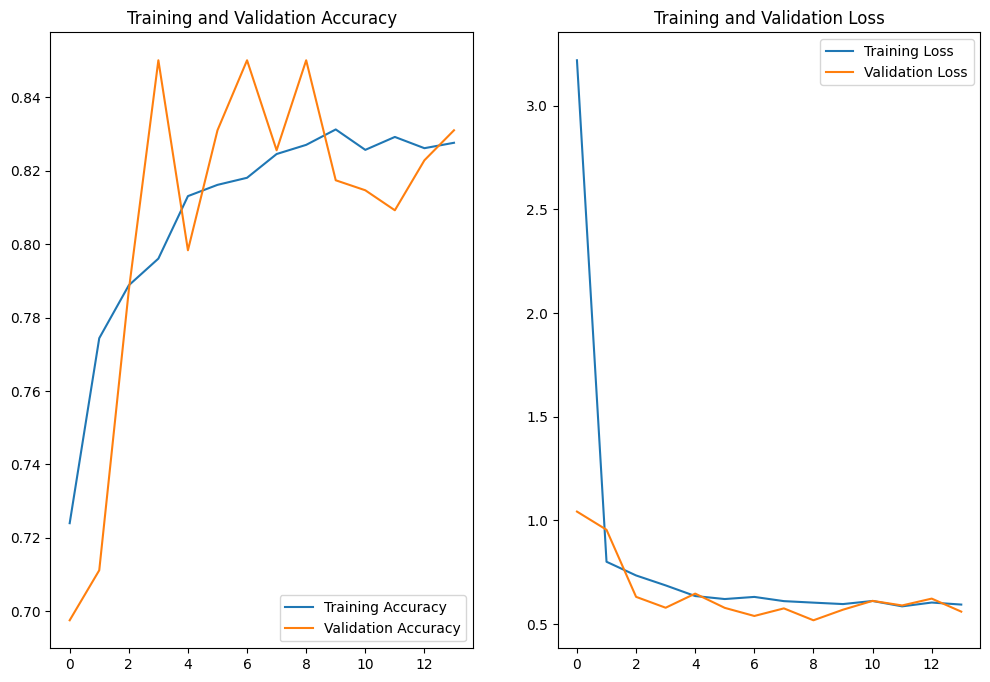

In [81]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(14)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [241]:
# 모델 예측
import numpy as np

# 배치에서 샘플 이미지 가져오기
image_batch, label_batch = next(iter(test_batches))

# 예측 수행
predictions = model.predict(image_batch)
predicted_labels = np.argmax(predictions, axis=1)  # 확률값이 가장 높은 클래스 선택
true_labels = label_batch.numpy()

# 이미지 시각화
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(image_batch, true_labels, predicted_labels)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2  # 정규화 해제
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'

    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

plt.show()

# 정확도 계산
correct_count = np.sum(true_labels == predicted_labels)
total_samples = len(true_labels)

print(f"정확도: {correct_count / total_samples * 100:.2f}%")
print(f"정확도 (배치 기준, 32개 샘플 중): {correct_count / 32 * 100:.2f}%")

Output hidden; open in https://colab.research.google.com to view.

In [257]:
# 전체 테스트 데이터셋 평가
test_loss, test_accuracy = model.evaluate(test_batches)

print(f"✅ 전체 테스트 데이터셋 정확도: {test_accuracy * 100:.2f}%")
print(f"✅ 전체 테스트 데이터셋 손실값: {test_loss:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.4923 - loss: 1.3587
✅ 전체 테스트 데이터셋 정확도: 48.58%
✅ 전체 테스트 데이터셋 손실값: 1.3554


In [243]:
# 전체 테스트 정확도 출력
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"✅ 전체 테스트 데이터셋 정확도: {test_accuracy * 100:.2f}%")

# 개별 샘플 예측 후 정확도 계산
all_predictions = []
all_labels = []

for image_batch, label_batch in test_batches:
    batch_predictions = model.predict(image_batch)
    predicted_labels = np.argmax(batch_predictions, axis=1)

    all_predictions.extend(predicted_labels)
    all_labels.extend(label_batch.numpy())

# 정확도 계산
correct_predictions = np.sum(np.array(all_labels) == np.array(all_predictions))
total_samples = len(all_labels)

print(f"✅ 테스트 데이터셋 전체 정확도(직접 계산): {correct_predictions / total_samples * 100:.2f}%")

# 클래스별 평가 출력
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions, target_names=[f"Class {i}" for i in range(5)]))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6875 - loss: 0.8670
✅ 전체 테스트 데이터셋 정확도: 70.60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
✅ 테스트 데이터셋 전체 정확도(직접 계산): 70.60%
              precision    reca